# HW5 : Kernel Methods for Regression

Official instructions:

https://www.cs.tufts.edu/comp/135/2020f/hw5.html

This is the starter code.

## Import relevant packages

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import time
import importlib
import itertools

In [2]:
import sklearn.linear_model
import sklearn.pipeline
import sklearn.metrics

In [3]:
# Plotting utils
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Load Training set data for the 'ByYear' split

Make sure you have downloaded the CSV files in the `data_melbourne_daily_min_temp` folder

In [8]:
DATA_DIR = os.path.join("data_melbourne_daily_min_temp") # TODO fix me

In [9]:
data_trByYear_df = pd.read_csv(os.path.join(DATA_DIR, 'data_train_ByYear.csv'))

In [10]:
# Inspect the first few entries
data_trByYear_df.head()

,date,years_since_19850101,temp_deg_C
0,1981-01-01,-4.002740,20.7
1,1981-01-02,-4.000000,17.9
2,1981-01-03,-3.997260,18.8
3,1981-01-04,-3.994521,14.6
4,1981-01-05,-3.991781,15.8


In [11]:
# Inspect the last few entries
data_trByYear_df.tail()

,date,years_since_19850101,temp_deg_C
2185,1986-12-27,1.986301,14.6
2186,1986-12-28,1.989041,14.2
2187,1986-12-29,1.991781,13.2
2188,1986-12-30,1.994521,11.7
2189,1986-12-31,1.997260,17.2


In [38]:
# Read relevant columns into numpy arrays for x and y

x_trByYear_N1 = data_trByYear_df['years_since_19850101'].values[:][:,np.newaxis].copy()
y_trByYear_N = data_trByYear_df['temp_deg_C'].values[:].copy()

print("Training data (ByYear split strategy)")
print("x_trByYear_N1.shape: %s" % str(x_trByYear_N1.shape))
print("y_trByYear_N.shape : %s" % str(y_trByYear_N.shape))
print("mean(y_trByYear_N) : %.3f" % np.mean(y_trByYear_N))

Training data (ByYear split strategy)
x_trByYear_N1.shape: (2190, 1)
y_trByYear_N.shape : (2190,)
mean(y_trByYear_N) : 11.003


# Load Validation set data for the 'ByYear' split

In [13]:
data_vaByYear_df = pd.read_csv(os.path.join(DATA_DIR, 'data_valid_ByYear.csv'))

data_vaByYear_df.head()

,date,years_since_19850101,temp_deg_C
0,1987-01-01,2.000000,12.3
1,1987-01-02,2.002740,13.8
2,1987-01-03,2.005479,15.3
3,1987-01-04,2.008219,15.6
4,1987-01-05,2.010959,16.2


In [14]:
x_vaByYear_T1 = data_vaByYear_df['years_since_19850101'].values[:][:,np.newaxis].copy()
y_vaByYear_T = data_vaByYear_df['temp_deg_C'].values[:].copy()

print("Validation data (ByYear split strategy)")
print("x_vaByYear_T1.shape: %s" % str(x_vaByYear_T1.shape))
print("y_vaByYear_T.shape : %s" % str(y_vaByYear_T.shape))
print("mean(y_vaByYear_T) : %.3f" % np.mean(y_vaByYear_T))

Validation data (ByYear split strategy)
x_vaByYear_T1.shape: (730, 1)
y_vaByYear_T.shape : (730,)
mean(y_vaByYear_T) : 11.413


# Plot both training and validation sets

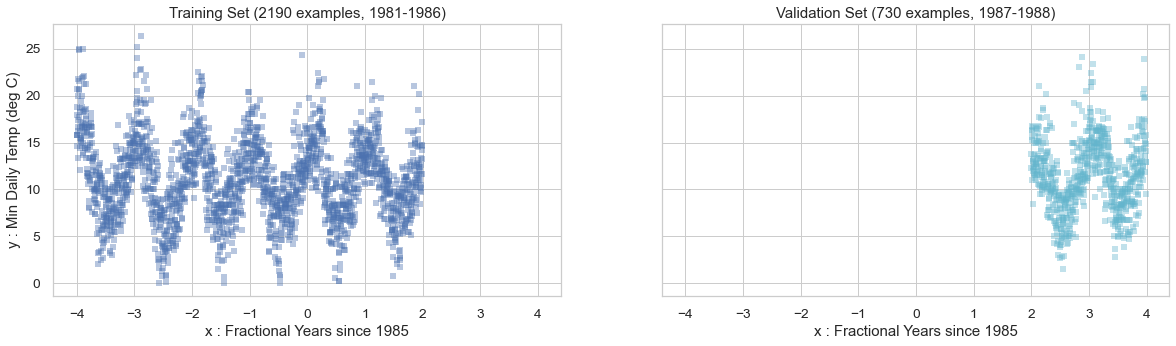

In [15]:
fig, axgrid = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,5))

axgrid[0].plot(x_trByYear_N1, y_trByYear_N, 'bs', alpha=0.4)
axgrid[0].set_xlabel('x : Fractional Years since 1985');
axgrid[0].set_title('Training Set (%d examples, %s-%s)' % (
    y_trByYear_N.size,
    pd.to_datetime(data_trByYear_df['date'].values[0]).year,
    pd.to_datetime(data_trByYear_df['date'].values[-1]).year))

axgrid[1].plot(x_vaByYear_T1, y_vaByYear_T, 'cs', alpha=0.4)
axgrid[1].set_xlabel('x : Fractional Years since 1985');
axgrid[1].set_title('Validation Set (%d examples, %s-%s)' % (
    y_vaByYear_T.size,
    pd.to_datetime(data_vaByYear_df['date'].values[0]).year,
    pd.to_datetime(data_vaByYear_df['date'].values[-1]).year))

axgrid[0].set_ylabel("y : Min Daily Temp (deg C)");

## Prepare to use sklearn splitter tools for hyperparameter search

### Prep a splitter object that knows which examples are 'train' and which are 'validation'

In [42]:
x_all_ByYear_L1 = np.vstack([x_trByYear_N1, x_vaByYear_T1])
y_all_ByYear_L = np.hstack([y_trByYear_N, y_vaByYear_T])
print(x_all_ByYear_L1.shape)
print(y_all_ByYear_L.shape)

(2920, 1)
(2920,)


In [17]:
# Create splitter object using Predefined Split
my_ByYear_splitter = sklearn.model_selection.PredefinedSplit(np.hstack([
    -1 * np.ones(y_trByYear_N.size), # -1 means never include this example in any test split
    0  * np.ones(y_vaByYear_T.size), #  0 means include in the first test split (we count starting at 0 in python)
    ]))

# Problem 3: Linear Kernel Regression Baseline



### Load kernel function from your completed `linear_kernel.py` file

In [18]:
import linear_kernel
importlib.reload(linear_kernel)

<module 'linear_kernel' from 'C:\\Users\\bq100\\github\\comp135-20f-assignments\\hw5\\linear_kernel.py'>

### Establish a pipeline for LInear Kernel Regression

Makes use of sklearn's `FunctionTransformer` (see [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html)), which will apply kernel function as first 'transformation' step in our pipeline.

This pipeline has two steps: 'linearkernelTransformer' and 'ridgeRegressor'

What happens when we call `fit(x_train_NF)` with this pipeline?

* 1) Transforms input features `x_train_NF` to kernel features `k_NN`
* * Entry i,j is the kernel between the i-th training feature and j-th training feature

* 2) Learns regression weight coefficient for each of the N columns of `k_NN`, by minimizing least squares objective with ridge penalty

$$
\min_{w \in \mathbb{R}^N, b} ~~ \sum_{n=1}^N (y_n - b - {\textstyle \sum_{i=1}^N w_i k(x_n, x_i)} )^2 ~ + \alpha \sum_{i=1}^N w_i^2
$$

What happens when we call `predict(x_QF)` with this pipeline?

* 1) Transform input features x_QF to the kernel features k_QN
* * Entry q,n is the kernel between the q-th test feature and n-th training feature

* 2) Apply the learned ridge regression to the k_QN 'kernel features'
* * Uses the learned weight coefficients for each of the N training examples to make a prediction

$$
\hat{y}(x_*) = b + {\textstyle \sum_{i=1}^N w_i k(x_*, x_i)} )^2 
$$

In [19]:
klr = sklearn.pipeline.Pipeline([
    ('linearkernelTransformer', sklearn.preprocessing.FunctionTransformer(linear_kernel.calc_linear_kernel)),
    ('ridgeRegressor', sklearn.linear_model.Ridge(alpha=1.0)),
    ])

### Setup grid search 

Performance metric:

* `neg_mean_absolute_error` ([docs](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules), uses sklearn's built-in [mean_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) metric, with negative sign to follow "higher is better" convention)

Hyperparameters to search:

* `alpha` penalty for RidgeRegression (larger values mean larger strength penalty on sum-of-squares of weights)

In [20]:
alpha_grid = np.logspace(-5, 5, 11)

print("Possible Values for ridgeRegressor__alpha")
for alpha in alpha_grid:
    print("% 11.3f" % alpha)

Possible Values for ridgeRegressor__alpha
      0.000
      0.000
      0.001
      0.010
      0.100
      1.000
     10.000
    100.000
   1000.000
  10000.000
 100000.000


In [21]:
# Create dictionary where:
# each key is a pipeline parameter name
# each value is a grid of possible values

klr_param_grid_by_name = dict(
    ridgeRegressor__alpha=alpha_grid,
    linearkernelTransformer__kw_args=[dict(x_train_NF=x_trByYear_N1)],
    )

#### TODO create the grid search

Make sure you use:

* The estimator defined above
* The parameter grid defined above
* The 'splitter' object defined above
* The 'scoring' performance metric defined above


In [25]:
# Package up into a sklearn GridSearch object

klr_grid_searcher = sklearn.model_selection.GridSearchCV(klr, klr_param_grid_by_name, scoring='neg_mean_absolute_error', cv=my_ByYear_splitter) # TODO fixme

### Run the grid search

In [26]:
start_time_sec = time.time()
klr_grid_searcher.fit(x_all_ByYear_L1, y_all_ByYear_L)
elapsed_time_sec = time.time() - start_time_sec

# Build dataframe of results
klr_search_results_df = pd.DataFrame(klr_grid_searcher.cv_results_).copy()
print("Grid search of %3d configurations done after %6.1f sec" % (
    klr_search_results_df.shape[0], elapsed_time_sec))

Grid search of  11 configurations done after    4.2 sec


### Display search results

#### TODO determine the best hyperparameters

In [34]:
print(klr_grid_searcher.best_params_)
best_alpha = 100000

{'linearkernelTransformer__kw_args': {'x_train_NF': array([[-4.00273973],
       [-4.        ],
       [-3.99726027],
       ...,
       [ 1.99178082],
       [ 1.99452055],
       [ 1.99726027]])}, 'ridgeRegressor__alpha': 100000.0}


### Refit model with best hyperparameters on ALL development data (train+valid)

In [35]:
#### TODO create new pipeline for ALL development data, using best hyperparameters

best_klr = sklearn.pipeline.Pipeline([
    ('linearkernelTransformer', sklearn.preprocessing.FunctionTransformer(
        linear_kernel.calc_linear_kernel,
        kw_args=dict(
            x_train_NF=x_all_ByYear_L1))),
    ('ridgeRegressor', sklearn.linear_model.Ridge(alpha=best_alpha)), # TODO make sure you use best alpha here
    ])

#### TODO fit model with the best hyperparameters

In [43]:
best_klr # TODO call fit on ALL development data (train + valid)
best_klr.fit(x_all_ByYear_L1, y_all_ByYear_L)

Pipeline(steps=[('linearkernelTransformer',
                 FunctionTransformer(func=<function calc_linear_kernel at 0x000001FEDD571AF0>,
                                     kw_args={'x_train_NF': array([[-4.00273973],
       [-4.        ],
       [-3.99726027],
       ...,
       [ 3.99178082],
       [ 3.99452055],
       [ 3.99726027]])})),
                ('ridgeRegressor', Ridge(alpha=100000))])

### Make figure of predictions and data side-by-side

Text(0, 0.5, 'Min Daily Temp (deg C)')

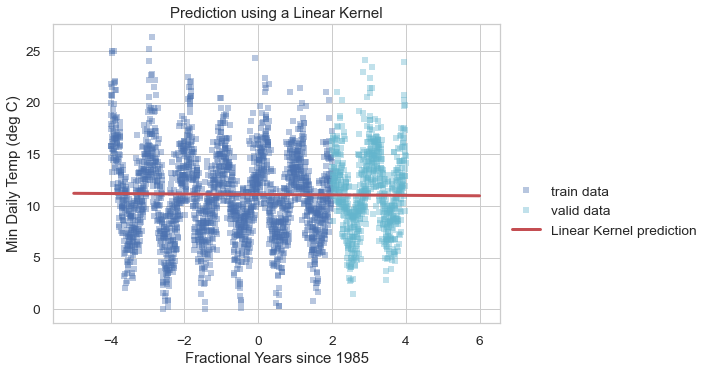

In [55]:
plt.plot(x_trByYear_N1, y_trByYear_N, 'bs', alpha=0.4, label='train data');
plt.plot(x_vaByYear_T1, y_vaByYear_T, 'cs', alpha=0.4, label='valid data');

L = 101
xgrid_L1 = np.linspace(-5, 6, L).reshape((L,1))

# TODO compute the predictions of the linear kernel regressor
yhat_L = best_klr.predict(xgrid_L1) # TODO fixme

# TODO Plot your predictions
plt.plot(xgrid_L1, yhat_L, 'r-', linewidth=3, label='Linear Kernel prediction');

plt.legend(bbox_to_anchor=(1.0, 0.5));
plt.title("Prediction using a Linear Kernel")
plt.xlabel("Fractional Years since 1985")
plt.ylabel("Min Daily Temp (deg C)")

# TODO don't forget your axis labels and title for this figure

# Problem 3: Squared Exponential Kernel Regression

In [45]:
import sqexp_kernel

# Allow any simultaneous edits to sqexp_kernel.py
# to be reloaded again into this notebook when this cell is executed
importlib.reload(sqexp_kernel)

<module 'sqexp_kernel' from 'C:\\Users\\bq100\\github\\comp135-20f-assignments\\hw5\\sqexp_kernel.py'>

### Establish a pipeline for SqExp Kernel Regression

Again, makes use of sklearn's `FunctionTransformer` (see [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html)), which will apply our `calc_sqexp_kernel` kernel function as first 'transformation' step in our pipeline.

In [46]:
sqexp_klr = sklearn.pipeline.Pipeline([
    ('sqexpKernelTransformer', sklearn.preprocessing.FunctionTransformer(sqexp_kernel.calc_sqexp_kernel)),
    ('ridgeRegressor', sklearn.linear_model.Ridge(alpha=1.0)),
    ])

### Setup grid search for SqExp Kernel hyperparameters

In [47]:
length_scale_grid = np.logspace(-2, 0, 9)
alpha_grid = np.logspace(-2, 3, 5)

print("Possible Values for sqexpKernelTransformer__kw_args['length_scale']")
for length_scale in length_scale_grid:
    print("% 11.3f" % length_scale)

print("Possible Values for ridgeRegressor__alpha")
for alpha in alpha_grid:
    print("% 11.3f" % alpha)

Possible Values for sqexpKernelTransformer__kw_args['length_scale']
      0.010
      0.018
      0.032
      0.056
      0.100
      0.178
      0.316
      0.562
      1.000
Possible Values for ridgeRegressor__alpha
      0.010
      0.178
      3.162
     56.234
   1000.000


In [48]:
# Create dictionary where:
# each key is a pipeline parameter name
# each value is a grid of possible values
sqexp_param_grid_by_name = dict(
    sqexpKernelTransformer__kw_args=[dict(
        length_scale=ell,
        x_train_NF=x_trByYear_N1,
        ) for ell in length_scale_grid],
    ridgeRegressor__alpha=alpha_grid,
    )

In [51]:
# Package up into a sklearn GridSearch object
sqexp_klr_grid_searcher = sklearn.model_selection.GridSearchCV(sqexp_klr, sqexp_param_grid_by_name, scoring='neg_mean_absolute_error', cv=my_ByYear_splitter, verbose=10, n_jobs = -1)

### Run grid search: find hyperparameters that yield best heldout predictions

In [52]:
start_time_sec = time.time()
sqexp_klr_grid_searcher.fit(x_all_ByYear_L1, y_all_ByYear_L)
elapsed_time_sec = time.time() - start_time_sec

# Build dataframe of results
sqexp_klr_search_results_df = pd.DataFrame(sqexp_klr_grid_searcher.cv_results_).copy()
print("Grid search of %3d configurations done after %6.1f sec" % (
    sqexp_klr_search_results_df.shape[0], elapsed_time_sec))

Fitting 1 folds for each of 45 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  19 out of  45 | elapsed:  3.5min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done  24 out of  45 | elapsed:  3.5min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  29 out of  45 | elapsed:  3.5min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  34 out of  45 | elapsed:  5.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  39 out of  45 | elapsed:  5.1min remaining:   46.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  5.1min finished


Grid search of  45 configurations done after  370.2 sec


### Display search results

#### TODO determine the best hyperparameters

In [56]:
print(sqexp_klr_grid_searcher.best_params_)
best_length_scale = 0.1778279410038923; # TODO
best_alpha = 3.1622776601683795; # TODO

{'ridgeRegressor__alpha': 3.1622776601683795, 'sqexpKernelTransformer__kw_args': {'length_scale': 0.1778279410038923, 'x_train_NF': array([[-4.00273973],
       [-4.        ],
       [-3.99726027],
       ...,
       [ 1.99178082],
       [ 1.99452055],
       [ 1.99726027]])}}


### Refit model with best hyperparameters on ALL development data (train+valid)

In [57]:
#### TODO create new pipeline for ALL development data, using best hyperparameters

best_sqexp_klr = sklearn.pipeline.Pipeline([
    ('sqexpKernelTransformer', sklearn.preprocessing.FunctionTransformer(
        sqexp_kernel.calc_sqexp_kernel,
        kw_args=dict(
            length_scale=best_length_scale, # TODO make sure you use best length scale here
            x_train_NF=x_all_ByYear_L1))),
    ('ridgeRegressor', sklearn.linear_model.Ridge(alpha=best_alpha)), # TODO make sure you use best alpha here
    ])

In [58]:
best_sqexp_klr # TODO call fit on ALL development data (train + valid)

best_sqexp_klr.fit(x_all_ByYear_L1, y_all_ByYear_L)

Pipeline(steps=[('sqexpKernelTransformer',
                 FunctionTransformer(func=<function calc_sqexp_kernel at 0x000001FEDD842A60>,
                                     kw_args={'length_scale': 0.1778279410038923,
                                              'x_train_NF': array([[-4.00273973],
       [-4.        ],
       [-3.99726027],
       ...,
       [ 3.99178082],
       [ 3.99452055],
       [ 3.99726027]])})),
                ('ridgeRegressor', Ridge(alpha=3.1622776601683795))])

### Figure 4: Predictions and actual temperatures for all data

Text(0, 0.5, 'Min Daily Temp (deg C)')

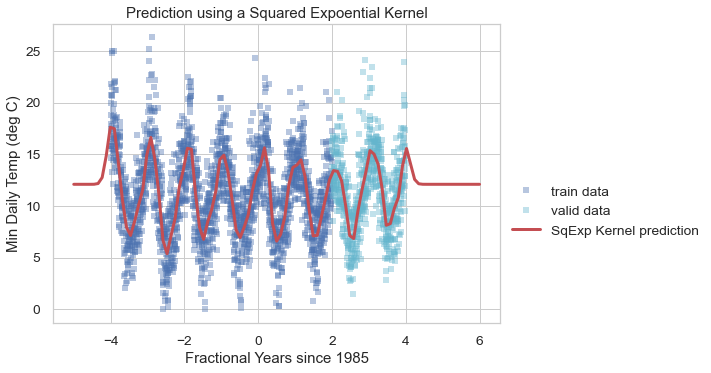

In [59]:
plt.plot(x_trByYear_N1, y_trByYear_N, 'bs', alpha=0.4, label='train data');
plt.plot(x_vaByYear_T1, y_vaByYear_T, 'cs', alpha=0.4, label='valid data');

L = 101
xgrid_L1 = np.linspace(-5, 6, L).reshape((L,1))

# TODO compute the predictions of the sqexp kernel regressor
yhat_L = best_sqexp_klr.predict(xgrid_L1) # TODO fixme

# TODO Plot your predictions
plt.plot(xgrid_L1, yhat_L, 'r-', linewidth=3, label='SqExp Kernel prediction');

plt.legend(bbox_to_anchor=(1.0, 0.5));
plt.title("Prediction using a Squared Expoential Kernel")
plt.xlabel("Fractional Years since 1985")
plt.ylabel("Min Daily Temp (deg C)")


# TODO don't forget your axis labels and title for this figure

# Problem 5: Periodic kernel

In [60]:
import periodic_kernel

# Allow any simultaneous edits to periodic_kernel.py
# to be reloaded again into this notebook when this cell is executed
importlib.reload(periodic_kernel)

<module 'periodic_kernel' from 'C:\\Users\\bq100\\github\\comp135-20f-assignments\\hw5\\periodic_kernel.py'>

In [61]:
periodic_klr = sklearn.pipeline.Pipeline([
    ('periodicKernelTransformer', sklearn.preprocessing.FunctionTransformer(periodic_kernel.calc_periodic_kernel)),
    ('ridgeRegressor', sklearn.linear_model.Ridge(alpha=1.0)),
    ])

In [62]:
periodic_grid = [0.5, 1.0, 1.5, 2.0]
length_scale_grid = [0.01, 0.03, 0.09, 0.27]
alpha_grid = [1.0, 10.0]

print("Possible Values for periodicKernelTransformer__kw_args['periodic']")
for period in periodic_grid:
    print("% 11.3f" % period)

print("Possible Values for periodicKernelTransformer__kw_args['length_scale']")
for length_scale in length_scale_grid:
    print("% 11.3f" % length_scale)

print("Possible Values for ridgeRegressor__alpha")
for alpha in alpha_grid:
    print("% 11.3f" % alpha)

Possible Values for periodicKernelTransformer__kw_args['periodic']
      0.500
      1.000
      1.500
      2.000
Possible Values for periodicKernelTransformer__kw_args['length_scale']
      0.010
      0.030
      0.090
      0.270
Possible Values for ridgeRegressor__alpha
      1.000
     10.000


In [63]:
periodic_param_grid_by_name = dict(
    periodicKernelTransformer__kw_args=[
        dict(length_scale=ell, period=p,
            x_train_NF=x_trByYear_N1) for (ell,p) in itertools.product(length_scale_grid, periodic_grid)],
    ridgeRegressor__alpha=alpha_grid,
    )

In [64]:
# Create grid search object

periodic_klr_grid_searcher = sklearn.model_selection.GridSearchCV(periodic_klr, periodic_param_grid_by_name, scoring='neg_mean_absolute_error', cv=my_ByYear_splitter, verbose=10, n_jobs = -1) # TODO fix me

### Run grid search for 'period' and 'length_scale' and 'alpha' hyperparameters

In [65]:
start_time_sec = time.time()
periodic_klr_grid_searcher.fit(x_all_ByYear_L1, y_all_ByYear_L)
elapsed_time_sec = time.time() - start_time_sec

# Build dataframe of results
periodic_klr_search_results_df = pd.DataFrame(periodic_klr_grid_searcher.cv_results_).copy()
print("Grid search of %3d configurations done after %6.1f sec" % (
    periodic_klr_search_results_df.shape[0], elapsed_time_sec))

Fitting 1 folds for each of 32 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  32 | elapsed:  1.5min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   9 out of  32 | elapsed:  1.5min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  13 out of  32 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  17 out of  32 | elapsed:  2.8min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  21 out of  32 | elapsed:  2.8min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  25 out of  32 | elapsed:  2.9min remaining:   47.9s
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:  2.9min remaining:   17.7s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  2.9min finished


Grid search of  32 configurations done after  225.8 sec


### Determine the best hyperparameters

#### TODO identify the best hyperparameter

In [67]:
print(periodic_klr_grid_searcher.best_params_)
best_alpha = 10.0
best_length_scale = 0.27
best_period = 1.0

{'periodicKernelTransformer__kw_args': {'length_scale': 0.27, 'period': 1.0, 'x_train_NF': array([[-4.00273973],
       [-4.        ],
       [-3.99726027],
       ...,
       [ 1.99178082],
       [ 1.99452055],
       [ 1.99726027]])}, 'ridgeRegressor__alpha': 10.0}


### Retrain model with best hyperparameters on ALL development data

In [68]:
best_periodic_klr = sklearn.pipeline.Pipeline([
    ('periodicKernelTransformer', sklearn.preprocessing.FunctionTransformer(
        periodic_kernel.calc_periodic_kernel,
        kw_args=dict(
            length_scale=best_length_scale,
            period=best_period,
            x_train_NF=x_all_ByYear_L1,
            ))),
    ('ridgeRegressor', sklearn.linear_model.Ridge(alpha=1.0)),
    ])

In [69]:
best_periodic_klr.fit(x_all_ByYear_L1, y_all_ByYear_L)

Pipeline(steps=[('periodicKernelTransformer',
                 FunctionTransformer(func=<function calc_periodic_kernel at 0x000001FE82690CA0>,
                                     kw_args={'length_scale': 0.27,
                                              'period': 1.0,
                                              'x_train_NF': array([[-4.00273973],
       [-4.        ],
       [-3.99726027],
       ...,
       [ 3.99178082],
       [ 3.99452055],
       [ 3.99726027]])})),
                ('ridgeRegressor', Ridge())])

Text(0, 0.5, 'Min Daily Temp (deg C)')

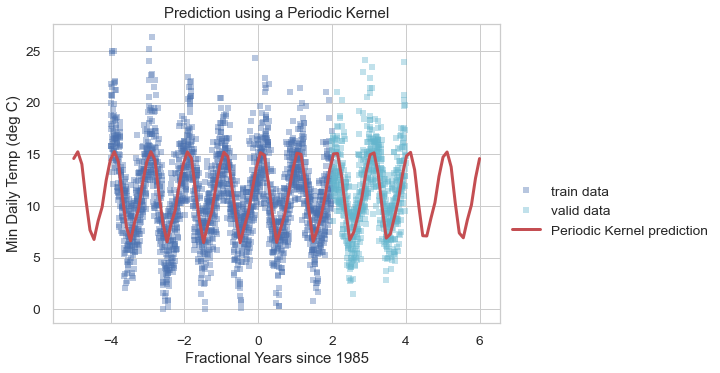

In [71]:
plt.plot(x_trByYear_N1, y_trByYear_N, 'bs', alpha=0.4, label='train data');
plt.plot(x_vaByYear_T1, y_vaByYear_T, 'cs', alpha=0.4, label='valid data');

L = 101
xgrid_L1 = np.linspace(-5, 6, L).reshape((L,1))

# TODO compute the predictions of the periodic kernel regressor
yhat_L = best_periodic_klr.predict(xgrid_L1) # TODO fixme

# TODO Plot your predictions
plt.plot(xgrid_L1, yhat_L, 'r-', linewidth=3, label='Periodic Kernel prediction');

plt.legend(bbox_to_anchor=(1.0, 0.5));
plt.title("Prediction using a Periodic Kernel")
plt.xlabel("Fractional Years since 1985")
plt.ylabel("Min Daily Temp (deg C)")

# TODO don't forget your axis labels and title for this figure

# Problem 6: Compare Methods on Test Set

### Load test data

In [72]:
data_te_df = pd.read_csv(os.path.join(DATA_DIR, 'data_test_ByYear.csv'))
x_te_T1 = data_te_df['years_since_19850101'].values[:][:,np.newaxis].copy()  # Load (T,1) feature values array
y_te_T = data_te_df['temp_deg_C'].values[:].copy()                           # Load (T,) feature values array

### Implement Baseline: Periodic nearest neighbor

#### TODO implement the method below to make baseline predictions

In [ ]:
def predict_periodic_nearest_neighbor(
        x_te_T1,
        x_all_ByYear_L1, y_all_ByYear_L,
        years_back=[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]):
    ''' Compute baseline prediction for each day in test set
    
    Args
    ----
    x_te_T1 : 2D array, shape (T, 1) = (n_test_examples, 1)
        Contains x features for the test set
    x_all_ByYear_L1 : 2D array, shape (n_trainvalid_examples, 1)
        Contains x features for train+valid set
    y_all_ByYear_L : 1D array, shape (n_trainvalid_examples,)
        Contains y response values for train+valid set
    
    Returns
    -------
    yhat_T : 1D array, shape (T,)
        Predicted y values for each test example
        Using 'periodic' nearest neighbors method
    '''
    assert x_te_T1.ndim == 2
    T, F = x_te_T1.shape
    
    # TODO compute the baseline
    yhat_T = np.zeros(T)
    
    return yhat_T


# Table 6: Comparison of methods on the test set

Please report MEAN ABSOLUTE ERROR on both the train+valid and test sets, to 3 digits of precision

### TODO make a table like this

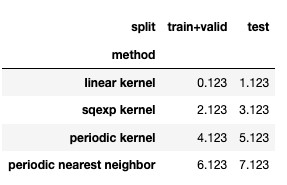